# WOW --- Wow! Ocean Worlds

This demo notebook demonstrates how to use WOW to simulate the thermal and chemical evolution of an ocean world. 

This demo model is for a Ceres-sized body. 

First, import required packages:

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

# required paths for other WOW files
main_directory=os.getcwd()+"/"
sys.path.insert(1, main_directory+'thermal')
sys.path.insert(1, main_directory+'aqueous')
sys.path.insert(1, main_directory+'transport')
sys.path.insert(1, main_directory+'rock')
sys.path.insert(1, main_directory+'tables')
sys.path.insert(1, main_directory+'plotting')

# 1). Import WOW!

WOW.py contains the backbone of the modeling code

In [2]:
import WOW

# 2). Create model grid

First, the modeling framework must be defined. There are 7 important parameters to set:
- nr: the number of radius steps in the model. The code is 1D, assuming the body is spherically-symmetric about the axis. So the radius steps correspond to concentric shells of the sphere. See the diagrams in the material/reading folder. 
- Radius: this is the radius of the body in meters. 
- StartTime: when the body formed, in seconds after the formation of CAIs. In practice, this age only affects the starting abundances of radioisotopes. See section 3c.

Stop criteria. The mode will stop when one of the following two criteria are met:
- maxnt: this is the maximum number of timesteps that the code will execute. 
- EndTime: The model will stop either when the max number of time steps is reached, or when the EndTime is reached. Since the time steps are dynamically calculated based on the material properties, the number of time steps necessary to reach a specific end time cannot be known in advance.

Practical constraints. The chemical equilibration step using Perple_X is time consuming. To reduce the number of calculations and speed up the simulation, these parameters denote how often to do chemical equilibration steps.
- temp_step: This is the number of degrees (in Kelvin) that a radius cell needs to change before the code attempts to update it's composition with Perple_X. Note that this only applies to mineral equilibration, and not phase changes, like melting ice. 
- press_step: Instead of running Perple_X equilibration for every radius cell, this parameter decides how many cells to skip between each equilibration. So press_step=10 means that a Perple_X equilibration will only occur for every 10 radius steps. The cells between these points inherit the composition of the nearest overlying equilibrated cell.

Finally, the function, WOW.Planet initializes the modeiling framework, creating the planet object that is composed of the specified number of radius cells. 

In [3]:
######### define grid ##############

nr = 50                  # Number of radii
maxnt = 2000             # Maximum number of time steps


YR    =   3.1536E7        #(seconds in a year, for easy conversion)
StartTime=4.5 * 10**6*YR  # Start time in seconds after CAIs  
EndTime = 4567* 10**6*YR  # End time in seconds after CAIs. Stop time if maxnt is not reached
Radius  = 480000          # Radius in meters



# parameters for perplex grid
temp_step = 15 # how many degrees (K) change before recalculating thermal properties? 
press_step= 10 # how many radius points between each perplex equilibration calculation?


# Initialize the planet
Ceres = WOW.Planet(nr,StartTime,EndTime,Radius,maxnt,temp_step,press_step)

# 3). Initialize model composition

Once the model framework has been created, the starting composition of the model can be specified. This includes:
- the starting temperature
- the starting bulk elemental composition
- the starting radioisotope abundances
- the starting bulk physcial properties

### 3a starting temperature

Each of the radius cells starts with this temperature. The surface of the body is fixed at this temperature, too.

In [4]:
# Starting temperature
init_Temp = 180   # K

### 3b starting bulk composition

The model is assumes a homegeneous starting composition. Every cell has the same composition. The composition is specified using elemental abundance fractions. 

There are 11 elements available in the demo Rcrust data and project file. Adding more would require altering those files.

The strating composition is split into an icy component and a rocky component. The icy component will melt and differntiate into a fluid that will form the primordial ocean. The rocky component will be used as inputs to the Rcrust mineral equilibration calculations. 

Water (as H and O) may still be added to the initial rock composition. After the first chemical equilibration step, much of the volatiles will likely be released from the mineral assemblage as fluids if they cannot be accounted for with hydrated minerals. 

Chaning the elemental abundances to abundances that have no reasonable molecular compositions will likely cause a crash.

In [5]:
########### initialize comp ############

# Ice composition (water ice, H2O, in this case)
init_IceComp={'H':1/9*100,
              'O':8/9*100}

# Rock composition (hydrated CI-chondrite-like)
init_RockComp={"H":4.751,
               "C":2.784,
               "Mg":7.313,
               "Al":0.676,
               "Si":7.746,
               "S":4.020,
               "Ca":0.693,
               "Fe":14.001,
               "O":57.196,
               "Na":0.403,
               "N":0.417}


# Mass fractions of ice relative to rocks (in this demo, we will start with all the mass in the rocky component)
ICE_frac = 0.001




#####################################################
# Don't change anything below
# Reweight rock and ice compositions so they sum to 1
# (Eventually this will be done behind the scenes)
sumR=0
for key in init_RockComp:    
    sumR = sumR+init_RockComp[key]
    init_RockComp[key] *= (1.0-ICE_frac)/100
    
sumI=0
for key in init_IceComp:    
    sumI = sumI+init_IceComp[key]
    init_IceComp[key] *= (ICE_frac/100)

init_RockComp["IOM"]=0 #init_orgMass

### 3c starting radioisotope abundances

The code requires starting abundances for five radioactive isotopes:
 - Al26
 - K40
 - U235
 - U238
 - Th232
 
These values should be entered as mole fractions for t=0 myrs after CAIs

In [6]:
# Radioactive elements starting abundance
# This demo uses abundances from ordinary chondrites
# since we're simulating a hydrated carbonaceous-chondrite-like body, we'll dilute the abundaces by 20%
dilution=0.20 
Al_tot_abund=(1-dilution)* 8370*10**-6     
K_tot_abund= (1-dilution)* 559*10**-6      
U_tot_abund= (1-dilution)* 0.00816*10**-6  
Th_tot_abund=(1-dilution)* 0.0298*10**-6   

# Radioisotope fractions
Al_26_27_start=5*10**-5    
K_40_39_today=0.0119/100 
U_235_238_today=0.71/100

# Calc initial radioisotope abundances
Al26start=Al_tot_abund*Al_26_27_start
K40start = WOW.calcOriginAbundance(K_tot_abund*K_40_39_today,"K40")
U235start= WOW.calcOriginAbundance(U_tot_abund*U_235_238_today,"U235")
U238start= WOW.calcOriginAbundance(U_tot_abund*(1-U_235_238_today),"U238")
Th232start=WOW.calcOriginAbundance(Th_tot_abund,"Th232")
# Initial radioisotope abundance
init_Radio={'Al26':Al26start,'K40':K40start,'U235':U235start,'U238':U238start,'Th232':Th232start}
print(init_Radio)

{'Al26': 3.348e-07, 'K40': 6.361807993992228e-07, 'U235': 4.179488357949731e-09, 'U238': 1.3167928157727384e-08, 'Th232': 2.988975741113468e-08}


### 3d intial bulk properties

Since the body begins as a homegenous undifferentiated object, the code doesn't assign physcial properties until the first chemical equilibration step. Until that step, the code needs starting physcial properties. 

- Density
- Thermal conductivity
- Heat capacity

In [7]:
# Starting bulk properties (will be updated after first Perple_X calculation)

# Ceres density
Ceres_Mass= 9.38*10**20 #kg
Ceres_Vol = 4.0/3.0*np.pi*Radius**3
Ceres_rho = Ceres_Mass/Ceres_Vol

# Starting properties
init_rho = Ceres_rho # kg/m^3 Density
init_K   = 0.5       # W/m^2  Thermal conductivity
init_Cp  = 1000      # J/kg/K Heat capacity

### 3e Initialize model
Finally, we can initialize the model's starting composition with all the previous info:
- Name of the model
- Ice composition
- Rock composition
- Radioisotopes
- Temperature
- Density
- Thermal conductivity
- Heat capacity

In [8]:
# initialize!
Ceres.initialize_comp("ceres", init_IceComp, init_RockComp, init_Radio, init_Temp, init_rho, init_K, init_Cp)

# 4). Run Model

Finally, we can execute the model simulation. The simulation will display a counter of the time step progress as it runs. 

Depending on how you configured the installations of Rcrust and EQ36, there may be warning messages displayed as the code runs. If the code encounters an error in an EQ36 or Rcrust equilibration calculation, it skips that step, preserving the previous composition, and tries again on the next step. This means that it's important to check the output for reasonable compositions. 



What makes the model slow:
- Executing Perplex. Every Perple_X execution requires opening R, loading the Rcrust package, and closing.
    - Future solution to be implemented: skip Rcrust, run Perplex fortran code directly. Likely need to modify fortran code though.
- Executing EQ36 aqueous equilibration at every time and radius step.
    - Future solution to be implemented: Only execute a new equilibration when a significant pressure, temperature, composition change has been made

In [9]:
Ceres.runModel()

Step 0 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 20 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 30 out of 2000
Step 40 out of 2000
Step 50 out of 2000
Step 60 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 70 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 80 out of 2000
Step 90 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 100 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 110 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 120 out of 2000
Step 130 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 140 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 150 out of 2000
Step 160 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 170 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 180 out of 2000
Step 190 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 200 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 210 out of 2000
Step 220 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 230 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 240 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 250 out of 2000
Step 260 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 270 out of 2000
Step 280 out of 2000
Step 290 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 300 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 310 out of 2000
Step 320 out of 2000
Step 330 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 340 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 350 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 360 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 370 out of 2000
Step 380 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 390 out of 2000
Step 400 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 410 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 420 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 430 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 440 out of 2000
Step 450 out of 2000
Step 460 out of 2000
Step 470 out of 2000
Step 480 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 490 out of 2000
Step 500 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres37.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102843187
#1  0x102843d37
#2  0x102844613
#3  0x10292ddc3
#4  0x10292e4d3
#5  0x10292af53
#6  0x10292f617
#7  0x1029306e3
#8  0x1024013b3
#9  0x10237560b
#10  0x102312963
#11  0x10240246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres37.6tx: No such file or directory
mv: /U

Step 510 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 520 out of 2000
Step 530 out of 2000
Step 540 out of 2000
Step 550 out of 2000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres30.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1007b3187
#1  0x1007b3d37
#2  0x1007b4613
#3  0x10089ddc3
#4  0x10089e4d3
#5  0x10089af53
#6  0x10089f617
#7  0x1008a06e3
#8  0x1002cd3b3
#9  0x10024160b
#10  0x1001de963
#11  0x1002ce46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres30.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres30.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres30.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres30.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres30.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 560 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 570 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 580 out of 2000
Step 590 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 600 out of 2000
Step 610 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres31.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100db7187
#1  0x100db7d37
#2  0x100db8613
#3  0x100ea1dc3
#4  0x100ea24d3
#5  0x100e9ef53
#6  0x100ea3617
#7  0x100ea46e3
#8  0x1008b53b3
#9  0x10082960b
#10  0x1007c6963
#11  0x1008b646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres31.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres31.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres31.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres31.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres31.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 620 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 630 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 640 out of 2000
Step 650 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres32.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100b17187
#1  0x100b17d37
#2  0x100b18613
#3  0x100c01dc3
#4  0x100c024d3
#5  0x100bfef53
#6  0x100c03617
#7  0x100c046e3
#8  0x1006fd3b3
#9  0x10067160b
#10  0x10060e963
#11  0x1006fe46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6ba: No such file or directory
Note: The following floating-point excepti

Step 660 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 670 out of 2000
Step 680 out of 2000
Step 690 out of 2000
Step 700 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 710 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 720 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 730 out of 2000
Step 740 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 750 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 760 out of 2000
Step 770 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres33.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100d8b187
#1  0x100d8bd37
#2  0x100d8c613
#3  0x100e75dc3
#4  0x100e764d3
#5  0x100e72f53
#6  0x100e77617
#7  0x100e786e3
#8  0x1008893b3
#9  0x1007fd60b
#10  0x10079a963
#11  0x10088a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres33.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres33.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres33.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres33.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 780 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres32.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10498b187
#1  0x10498bd37
#2  0x10498c613
#3  0x104a75dc3
#4  0x104a764d3
#5  0x104a72f53
#6  0x104a77617
#7  0x104a786e3
#8  0x1045653b3
#9  0x1044d960b
#10  0x104476963
#11  0x10456646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres32.6ba: No such file or directory
Note: The following floating-point excepti

Step 790 out of 2000
Step 800 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 810 out of 2000
Step 820 out of 2000
Step 830 out of 2000
Step 840 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 850 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 860 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 870 out of 2000
Step 880 out of 2000
Step 890 out of 2000
Step 900 out of 2000
Step 910 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 920 out of 2000
Step 930 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 940 out of 2000
Step 950 out of 2000
Step 960 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 970 out of 2000
Step 980 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 990 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1000 out of 2000
Step 1010 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1020 out of 2000
Step 1030 out of 2000
Step 1040 out of 2000
Step 1050 out of 2000
Step 1060 out of 2000
Step 1070 out of 2000
Step 1080 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres38.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1011b3187
#1  0x1011b3d37
#2  0x1011b4613
#3  0x10129ddc3
#4  0x10129e4d3
#5  0x10129af53
#6  0x10129f617
#7  0x1012a06e3
#8  0x100ce93b3
#9  0x100c5d60b
#10  0x100bfa963
#11  0x100cea46f
mv: /Users/samuelc

Step 1090 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1100 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1110 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres33.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10291f187
#1  0x10291fd37
#2  0x102920613
#3  0x102a09dc3
#4  0x102a0a4d3
#5  0x102a06f53
#6  0x102a0b617
#7  0x102a0c6e3
#8  0x1024d13b3
#9  0x10244560b
#10  0x1023e2963
#11  0x1024d246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres33.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres33.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres33.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres33.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 1120 out of 2000
Step 1130 out of 2000
Step 1140 out of 2000
Step 1150 out of 2000
Step 1160 out of 2000
Step 1170 out of 2000
Step 1180 out of 2000
Step 1190 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1200 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres34.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100683187
#1  0x100683d37
#2  0x100684613
#3  0x10076ddc3
#4  0x10076e4d3
#5  0x10076af53
#6  0x10076f617
#7  0x1007706e3
#8  0x1002513b3
#9  0x1001c560b
#10  0x100162963
#11  0x10025246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres34.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres34.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres34.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres34.6bb

Step 1210 out of 2000
Step 1220 out of 2000
Step 1230 out of 2000
Step 1240 out of 2000
Step 1250 out of 2000
Step 1260 out of 2000
Step 1270 out of 2000
Step 1280 out of 2000
Step 1290 out of 2000
Step 1300 out of 2000
Step 1310 out of 2000
Step 1320 out of 2000
Step 1330 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1340 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1350 out of 2000
Step 1360 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1370 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1380 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1390 out of 2000
Step 1400 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1410 out of 2000
Step 1420 out of 2000
Step 1430 out of 2000
Step 1440 out of 2000
Step 1450 out of 2000
Step 1460 out of 2000
Step 1470 out of 2000
Step 1480 out of 2000
Step 1490 out of 2000
Step 1500 out of 2000
Step 1510 out of 2000
Step 1520 out of 2000
Step 1530 out of 2000
Step 1540 out of 2000
Step 1550 out of 2000
Step 1560 out of 2000
Step 1570 out of 2000
Step 1580 out of 2000
Step 1590 out of 2000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1600 out of 2000
Step 1610 out of 2000
Step 1620 out of 2000
Step 1630 out of 2000
Step 1640 out of 2000
Step 1650 out of 2000
Step 1660 out of 2000
Step 1670 out of 2000
Step 1680 out of 2000
Step 1690 out of 2000
Step 1700 out of 2000
Step 1710 out of 2000
Step 1720 out of 2000
Step 1730 out of 2000
Step 1740 out of 2000
Step 1750 out of 2000
Step 1760 out of 2000
Step 1770 out of 2000
Step 1780 out of 2000
Step 1790 out of 2000
Step 1800 out of 2000
Step 1810 out of 2000
Step 1820 out of 2000
Step 1830 out of 2000
Step 1840 out of 2000
Step 1850 out of 2000
Step 1860 out of 2000
Step 1870 out of 2000
Step 1880 out of 2000
Step 1890 out of 2000
Step 1900 out of 2000
Step 1910 out of 2000
Step 1920 out of 2000
Step 1930 out of 2000
Step 1940 out of 2000
Step 1950 out of 2000
Step 1960 out of 2000
Step 1970 out of 2000
Step 1980 out of 2000
Step 1990 out of 2000


# 5). Plot results!

Plot attributes of the model

In [10]:
stime=Ceres.times[0] /3.154e+7/1e6 # convert model time to Myrs
etime=Ceres.times[-1]/3.154e+7/1e6 # convert model time to Myrs

### 5.1 Plot temperature

(4.499429296131896, 2099.8401946203962)

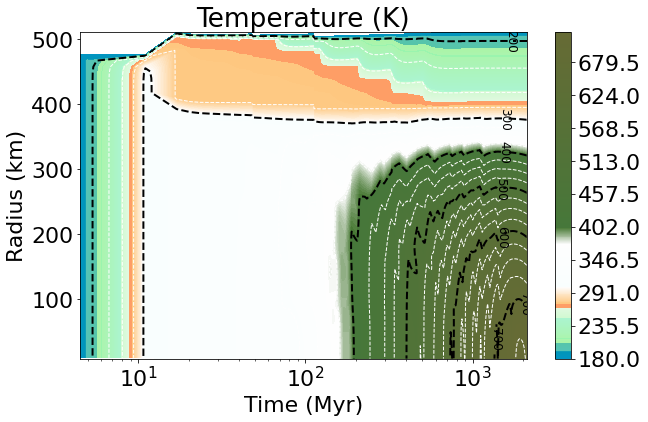

In [11]:
Ceres.plotTemp("Temp","Temperature (K)")
plt.xscale("log")
plt.xlim([stime,etime])

### 5.2 Plot mineral phases
 - All phases

/Users/samuelcourville/Documents/JPL/combinedModel/WOW.py:1415: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


(4.499429296131896, 2099.8401946203962)

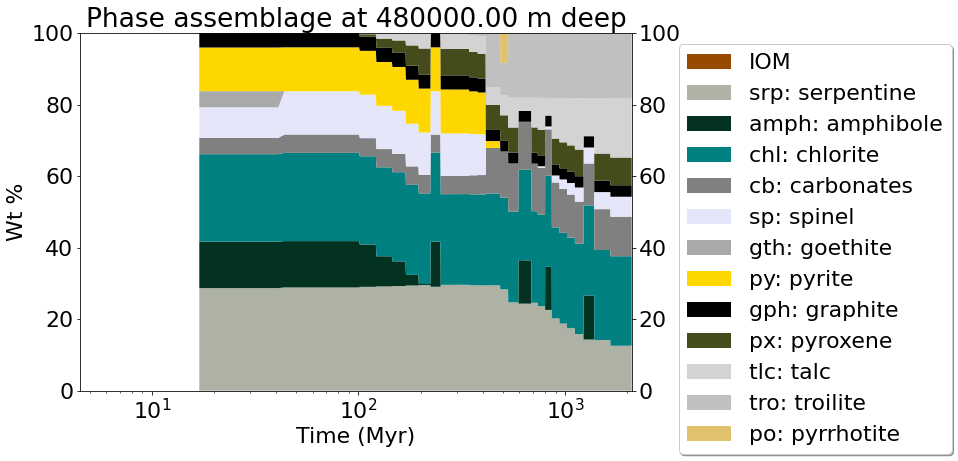

In [12]:
ax = Ceres.plotPhaseAssemblage(0,[])
plt.xscale("log")
plt.xlim([stime,etime])

- simplified

/Users/samuelcourville/Documents/JPL/combinedModel/WOW.py:1276: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j] = pP[i][j] / sumM[j] * (100 - IOMp)


(4.499429296131896, 2099.8401946203962)

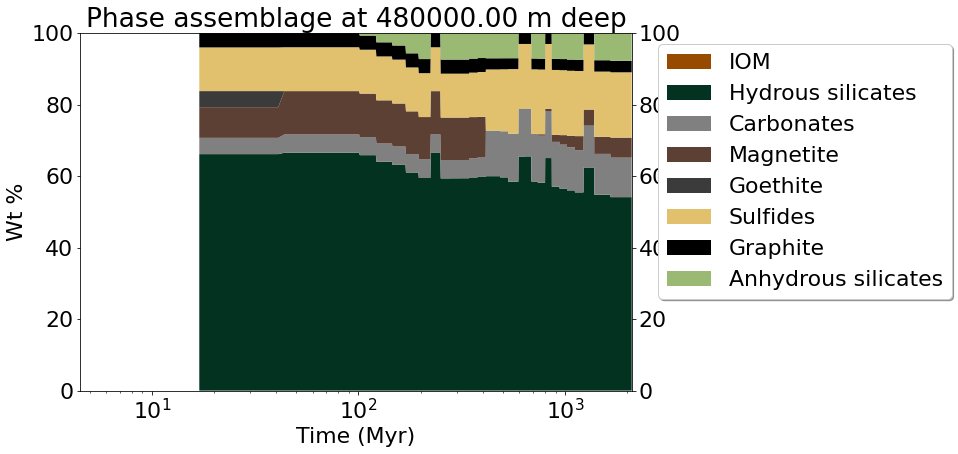

In [13]:
ax = Ceres.plotSimplePhases(0,["iron"])
plt.xscale("log")
plt.xlim([stime,etime])

### 5.3 Bulk properties
- heat capacity
- thermal conductivity
- density
- pressure

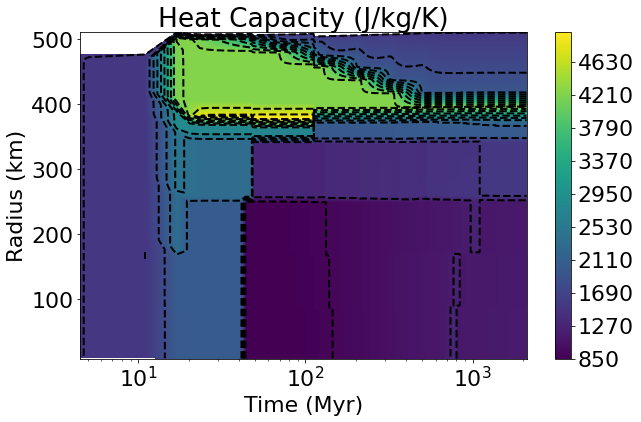

In [14]:
plt.rc('image', cmap='viridis')
Ceres.plotAttribute("Cp","Heat Capacity (J/kg/K)")
plt.xscale("log")

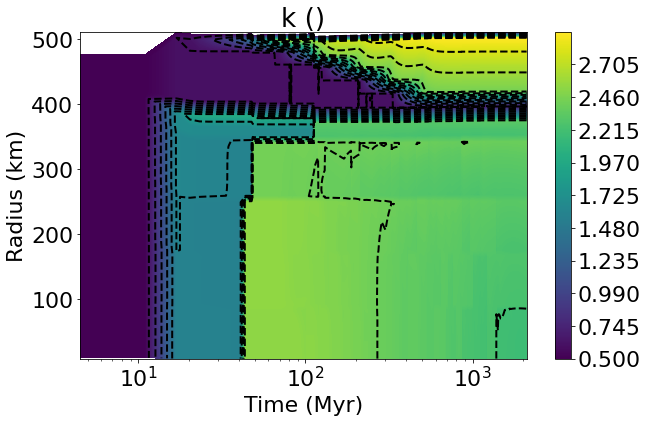

In [15]:
Ceres.plotAttribute("TCond","k ()")
plt.xscale("log")

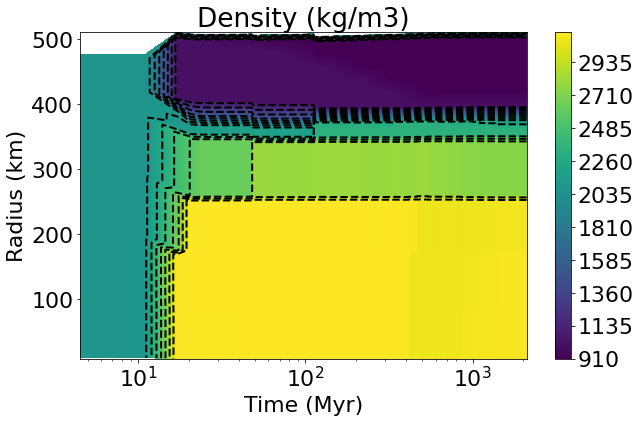

In [16]:
Ceres.plotAttribute("Dens","Density (kg/m3)")
plt.xscale("log")

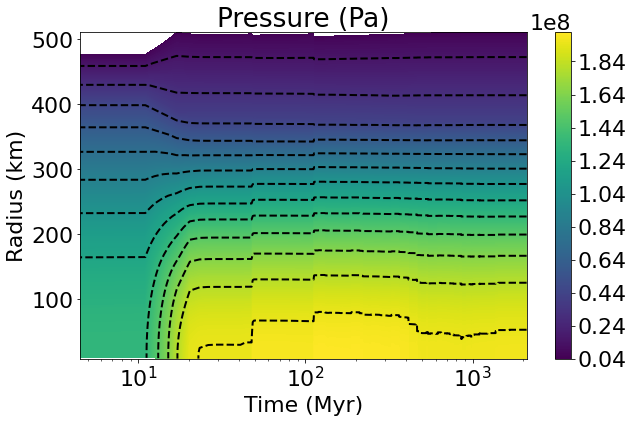

In [17]:
Ceres.plotAttribute("Press","Pressure (Pa)")
plt.xscale("log")

### 5.4 Radioisotope abundances

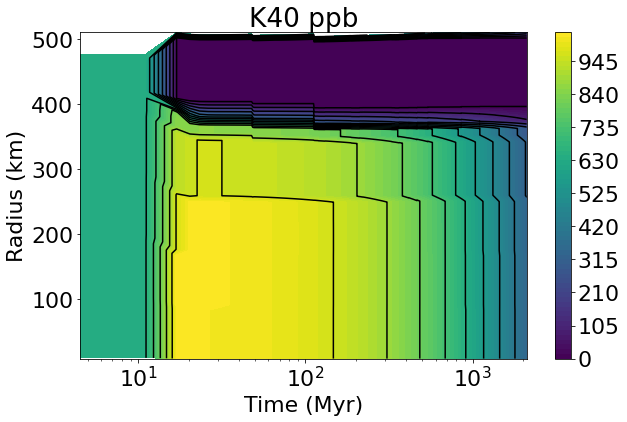

In [18]:
Ceres.plotDictAttribute("RIComp","K40","K40 ppb",10**9)
plt.xscale("log")

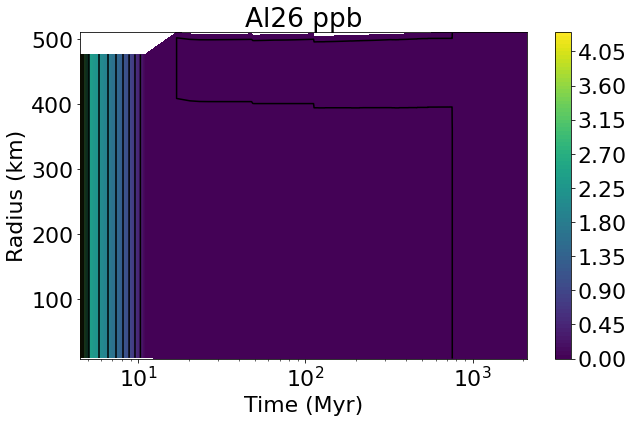

In [19]:
Ceres.plotDictAttribute("RIComp","Al26","Al26 ppb",10**9)
plt.xscale("log")

### 5.5 Structure
- Ocean mass

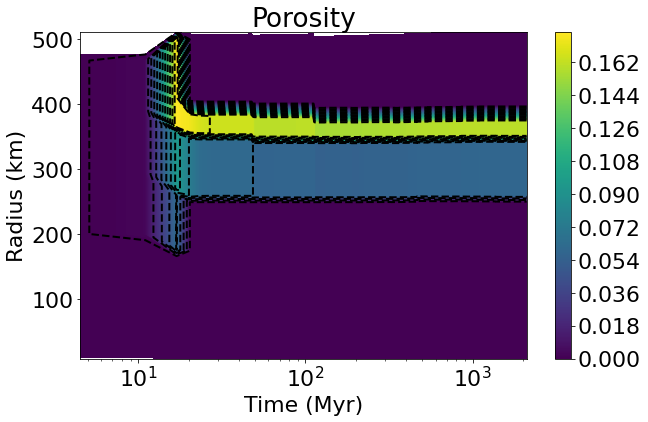

In [20]:
Ceres.plotAttribute("Porosity","Porosity")
plt.xscale("log")

- Cell types (Rock, ocean, ice, or mixed)

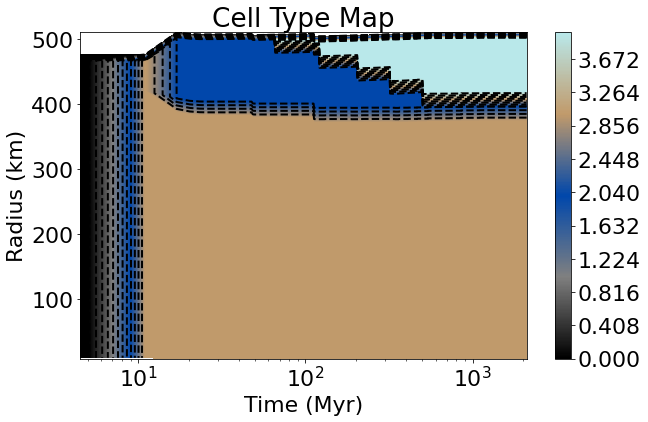

In [21]:
from matplotlib.colors import LinearSegmentedColormap
# Define the colors and ranges
colors = ['black', 'grey', '#0047AB', '#C19A6B', '#b9e8ea']
# Create a colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
plt.rc('image', cmap=custom_cmap)
Ceres.plotAttribute("Celltype","Cell Type Map")
plt.xscale("log")

### 5.6 Aqueous species in ocean
- Index ocean for species at that time

In [22]:
j=99      # time index
depth=35   # depth index
for i in Ceres.grid[j,depth].AqSpec:
    if Ceres.grid[j,depth].AqSpec[i]>10**-10:
        print(i+": "+str(Ceres.grid[j,depth].AqSpec[i])+" M")

H+: 6.7624e-09 M
Cl-: 0.014332 M
OH-: 4.4656e-05 M
H2(aq): 1.524e-07 M
SiO2(aq): 0.00011025 M
CO2(aq): 0.00011222 M
Ca++: 8.4934e-07 M
Na+: 0.015896 M
Mg++: 2.2249e-05 M
Fe++: 1.1613e-07 M
N2(aq): 0.0022524 M
H2S(aq): 3.0256e-08 M
NH4+: 0.030277 M
MgCl+: 1.2697e-07 M
FeCl+: 6.4789e-10 M
NaCl(aq): 2.8458e-05 M
CaCl+: 1.332e-09 M
HCO3-: 0.028302 M
Methane(aq): 0.081857 M
HS-: 2.3666e-06 M
NH3(aq): 0.021305 M
HSiO3-: 1.6779e-05 M
Formic_acid(aq): 1.0694e-10 M
HAlO2(aq): 3.0821e-09 M
Formate: 4.7441e-06 M
MgHCO3+: 4.8471e-06 M
CO3--: 0.001756 M
CaHCO3+: 1.6983e-07 M
Acetic_acid(aq): 1.6936e-09 M
Ethane(aq): 4.4012e-07 M
NaOH(aq): 7.287e-08 M
NaHSiO3(aq): 3.593e-06 M
Acetate: 8.3934e-06 M
Mg(For)+: 8.6387e-10 M
AlO2-: 1.1271e-06 M
MgCO3(aq): 1.1242e-05 M
CaCO3(aq): 1.2906e-06 M
Na(For)(aq): 4.7094e-08 M
MgCH3COO+: 1.3427e-09 M
Acetamide(aq): 8.8317e-07 M
NH4CH3COO(aq): 2.7347e-07 M
NaCH3COO(aq): 6.6487e-08 M
Propanoate: 3.3555e-09 M
Methionine(aq): 1.9318e-10 M
NaAlO2(aq): 3.0563e-09 M
Urea

- Sulfur species

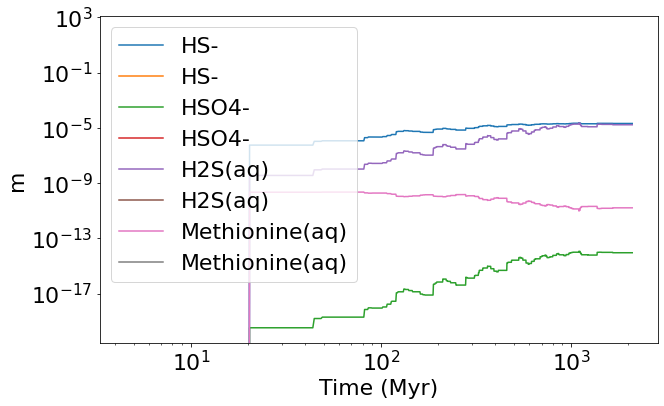

In [23]:
depth=35   # depth index

Ceres.multiplotDictAttributeLine("AqSpec",["HS-","HSO4-","H2S(aq)","Methionine(aq)"],"m",depth,1)
plt.yscale('log')
plt.xscale('log')

# Legend duplicates species for some reason (need to fix)

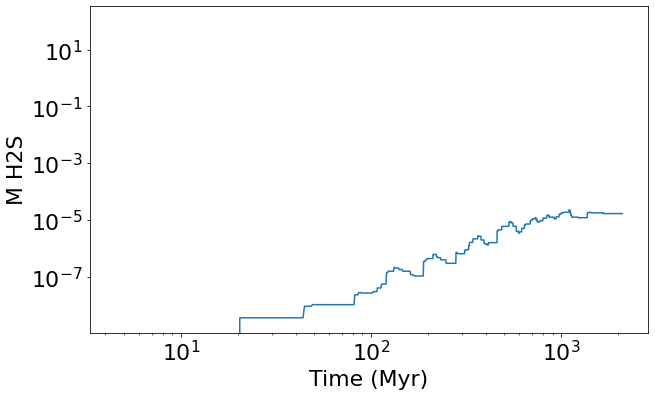

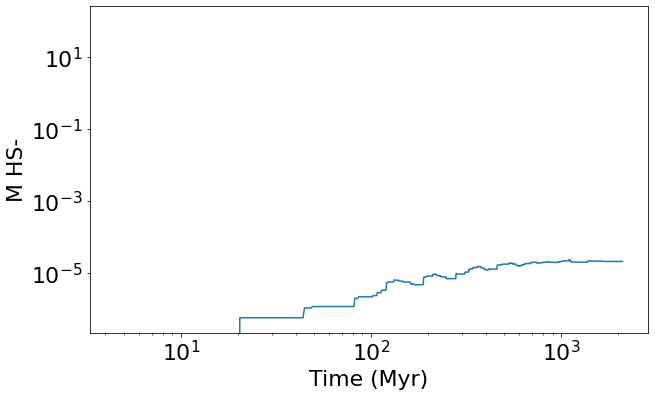

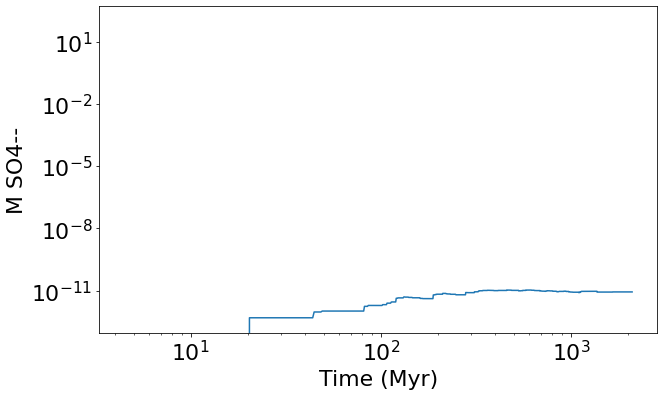

In [24]:
depth=35   # depth index

f,H2S=Ceres.plotDictAttributeLine("AqSpec","H2S(aq)","M H2S",depth,1)
plt.yscale('log')
plt.xscale('log')
f,HS=Ceres.plotDictAttributeLine("AqSpec","HS-","M HS-",depth,1)
plt.yscale('log')
plt.xscale('log')
f,SO4=Ceres.plotDictAttributeLine("AqSpec","SO4--","M SO4--",depth,1)
plt.yscale('log')
plt.xscale('log')


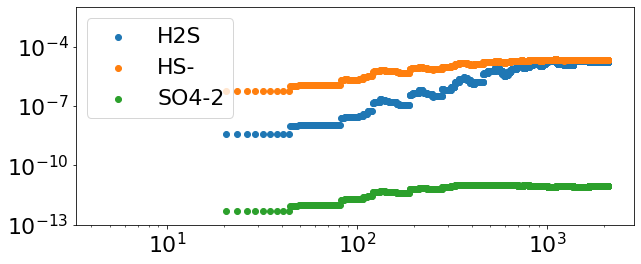

In [25]:
axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,H2S,label="H2S")
plt.scatter(Ceres.times/3.154e+7/1e6,HS,label="HS-")
plt.scatter(Ceres.times/3.154e+7/1e6,SO4,label="SO4-2")
#plt.scatter(Ceres.times/3.154e+7/1e6,Meth,label="Methionine")
plt.legend(loc="upper left")
plt.ylim([10**-13,10**-2])
plt.yscale('log')
plt.xscale('log')

- basic carbon species

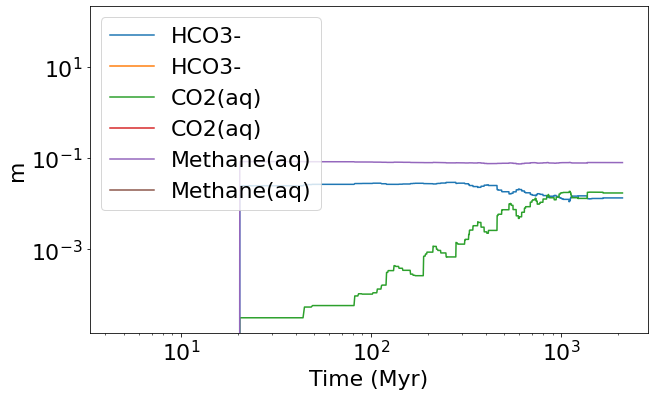

In [26]:
depth=35   # depth index
Ceres.multiplotDictAttributeLine("AqSpec",["HCO3-","CO2(aq)","Methane(aq)"],"m",depth,1)
plt.yscale('log')
plt.xscale('log')

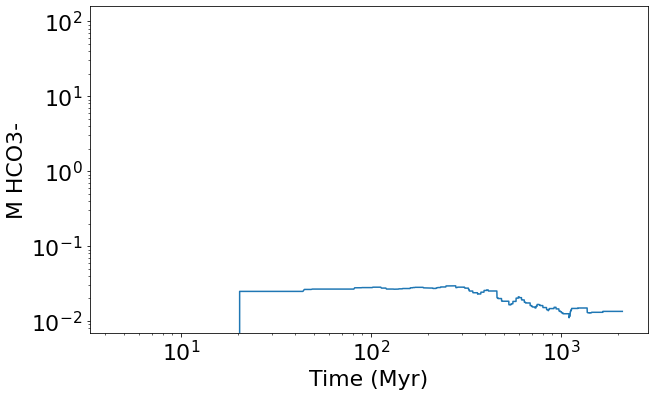

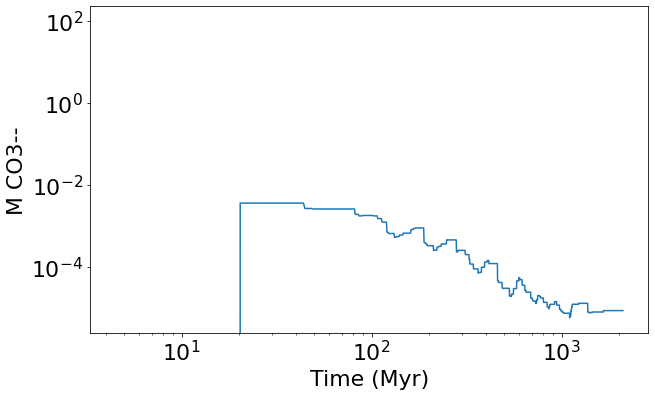

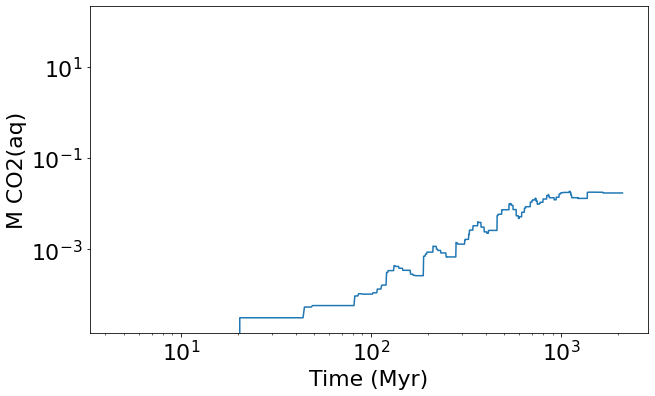

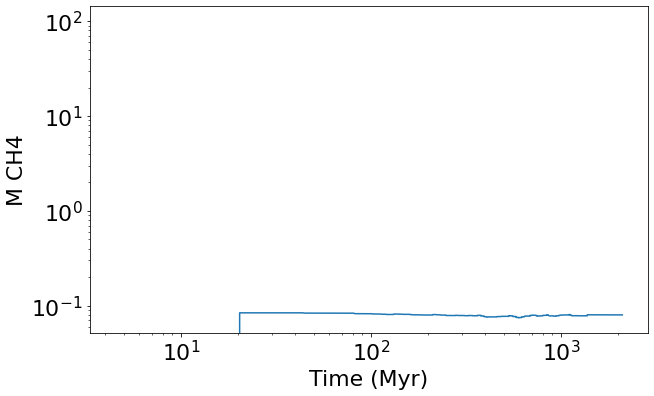

In [27]:
depth=35   # depth index

f,HCO3=Ceres.plotDictAttributeLine("AqSpec","HCO3-","M HCO3-",depth,1)
plt.yscale('log')
plt.xscale('log')
f,CO3=Ceres.plotDictAttributeLine("AqSpec","CO3--","M CO3--",depth,1)
plt.yscale('log')
plt.xscale('log')
f,CO2=Ceres.plotDictAttributeLine("AqSpec","CO2(aq)","M CO2(aq)",depth,1)
plt.yscale('log')
plt.xscale('log')
f,CH4=Ceres.plotDictAttributeLine("AqSpec","Methane(aq)","M CH4",depth,1)
plt.yscale('log')
plt.xscale('log')

# Plotting functions not working right now (need to fix)
# See combined plot below

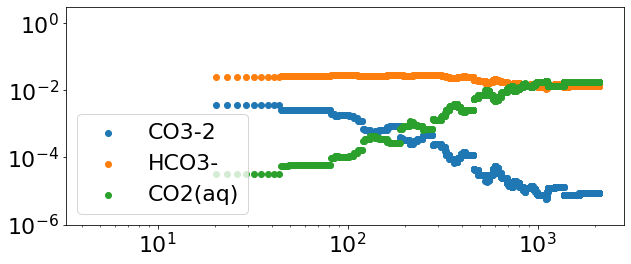

In [28]:
axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,CO3,label="CO3-2")
plt.scatter(Ceres.times/3.154e+7/1e6,HCO3,label="HCO3-")
plt.scatter(Ceres.times/3.154e+7/1e6,CO2,label="CO2(aq)")
#plt.scatter(Ceres.times/3.154e+7/1e6,CH4,label="CH4(aq)")
plt.legend()#location="NW")
plt.ylim([10**-6,3])
plt.yscale('log')
plt.xscale('log')

- pH

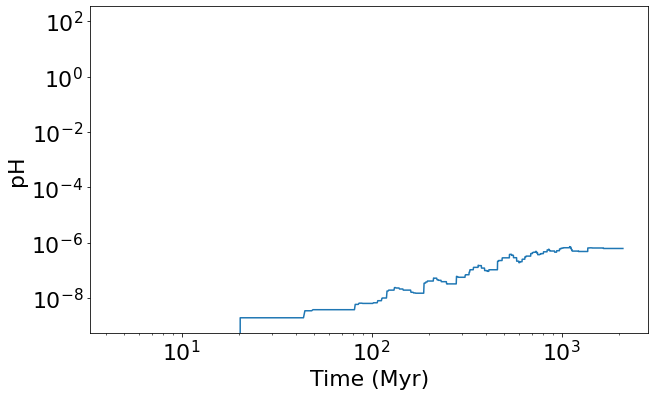

In [29]:
depth=35   # depth index

f,H=Ceres.plotDictAttributeLine("AqSpec","H+","pH",depth,1)
plt.yscale('log')
plt.xscale('log')

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_93717/779799975.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(Ceres.times/3.154e+7/1e6,-np.log10(H),color="k")


Text(0.5, 0, 'Time (Myr)')

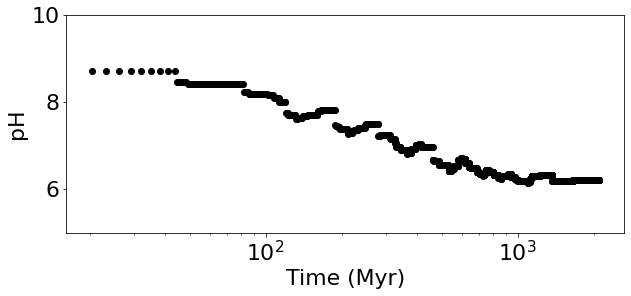

In [30]:

axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,-np.log10(H),color="k")
plt.ylim([5,10])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel("pH")
plt.xlabel("Time (Myr)")